In [5]:
from model import load_model
import numpy as np
from typing import Dict, Any, List
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

face_model = load_model()

In [6]:
import zipfile
import os

zip_file_name = "id_samples.zip"
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('id_samples')

zip_file_name = "test_samples.zip"
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('test_samples')

In [7]:
!unzip id_samples.zip
!unzip test_samples.zip

Archive:  id_samples.zip
  inflating: id_samples/Abbas_Kiarostami_1.jpg  
  inflating: id_samples/Abbas_Kiarostami_2.jpg  
  inflating: id_samples/Abbas_Kiarostami_3.jpg  
  inflating: id_samples/Abdullah_Gul_1.jpg  
  inflating: id_samples/Abdullah_Gul_2.jpg  
  inflating: id_samples/Abdullah_Gul_3.jpg  
  inflating: id_samples/Abdullah_al-Attiyah_1.jpg  
  inflating: id_samples/Abdullah_al-Attiyah_2.jpg  
  inflating: id_samples/Abdullah_al-Attiyah_3.jpg  
  inflating: id_samples/Adel_Al-Jubeir_1.jpg  
  inflating: id_samples/Adel_Al-Jubeir_2.jpg  
  inflating: id_samples/Adel_Al-Jubeir_3.jpg  
  inflating: id_samples/Adrian_McPherson_1.jpg  
  inflating: id_samples/Adrian_McPherson_2.jpg  
  inflating: id_samples/Adrian_McPherson_3.jpg  
  inflating: id_samples/Afton_Smith_1.jpg  
  inflating: id_samples/Afton_Smith_2.jpg  
  inflating: id_samples/Afton_Smith_3.jpg  
  inflating: id_samples/Aishwarya_Rai_1.jpg  
  inflating: id_samples/Aishwarya_Rai_2.jpg  
  inflating: id_samples/A

In [8]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from scipy.spatial.distance import cdist
from PIL import Image
import os
import random

В следующем классе представлены транформации, ухудшающие качество картинок с лицами, применены такие трансформации, как: изменение размера, добавление шума, ротация, изменение оттенков и насыщенности

In [66]:
class LowQualityTransform:
    def __init__(self, downscale_factor=0.6, noise_std=0.9, blur_radius=13):
        self.downscale = transforms.Resize((int(256 * downscale_factor), int(256 * downscale_factor)))
        self.upsample = transforms.Resize((256, 256))
        self.noise_std = noise_std
        self.blur = transforms.GaussianBlur(blur_radius)
        self.color_jitter = transforms.ColorJitter(brightness=0.7, contrast=0.6, saturation=0.5, hue=0.3)
        self.random_crop = transforms.RandomResizedCrop(size=(160, 160), scale=(0.7, 0.9))
        self.rand_rotate = transforms.RandomRotation(random.randint(270,360))



    def __call__(self, img):
        img = self.random_crop(img)
        img = self.rand_rotate(img)
        img = self.color_jitter(img)
        img = self.downscale(img)
        img = self.upsample(img)
        img = np.array(img)
        img = img + np.random.normal(0, self.noise_std, img.shape)
        img = np.clip(img, 0, 255).astype(np.uint8)
        img = Image.fromarray(img)
        img = self.blur(img)
        return img

In [67]:
def apply_transform_to_images(image_list, transform):
    transformed_images = []
    for img in image_list:
        transformed_img = transform(img)
        transformed_images.append(transformed_img)
    return transformed_images

In [68]:
def get_image_paths(folder):
    image_extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.tiff']
    return [os.path.join(folder, file) for file in os.listdir(folder) if os.path.splitext(file)[1].lower() in image_extensions]

ood_image_paths = get_image_paths("id_samples")
ood_image_paths

['id_samples/Hee-Won_Han_3.jpg',
 'id_samples/John_Burkett_3.jpg',
 'id_samples/Junichi_Inamoto_1.jpg',
 'id_samples/Martin_Cauchon_1.jpg',
 'id_samples/BJ_Habibie_2.jpg',
 'id_samples/Nicolas_Massu_2.jpg',
 'id_samples/Peter_OToole_1.jpg',
 'id_samples/BJ_Habibie_3.jpg',
 'id_samples/Steve_Nash_3.jpg',
 'id_samples/Doug_Christie_1.jpg',
 'id_samples/Kareena_Kapoor_1.jpg',
 'id_samples/Lew_Rywin_3.jpg',
 'id_samples/Ted_Maher_2.jpg',
 'id_samples/Laura_Schlessinger_3.jpg',
 'id_samples/Matt_Doherty_3.jpg',
 'id_samples/Caroline_Link_2.jpg',
 'id_samples/Javier_Solana_2.jpg',
 'id_samples/Richard_Perle_1.jpg',
 'id_samples/Ion_Iliescu_2.jpg',
 'id_samples/Ari_Fleischer_2.jpg',
 'id_samples/Anthony_Rackauckas_2.jpg',
 'id_samples/Sean_Hayes_1.jpg',
 'id_samples/Guillaume_Soro_1.jpg',
 'id_samples/Ashley_Postell_3.jpg',
 'id_samples/Serge_Tchuruk_3.jpg',
 'id_samples/Akbar_Al_Baker_1.jpg',
 'id_samples/Steven_Hatfill_1.jpg',
 'id_samples/Toni_Jennings_2.jpg',
 'id_samples/Rick_Wagoner_2.j

In [69]:
image_list = [Image.open(path) for path in ood_image_paths]

In [70]:
transform = LowQualityTransform()
transformed_images = apply_transform_to_images(image_list, transform)

In [71]:
import matplotlib.pyplot as plt

def plot_images(original_images, transformed_images):
    num_images = len(original_images)
    plt.figure(figsize=(12, 6))

    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i])
        plt.title(f"Original {i+1}")
        plt.axis('off')

        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(transformed_images[i])
        plt.title(f"Transformed {i+1}")
        plt.axis('off')

    plt.show()

In [72]:
import os

save_dir = 'transformed'
transformed_img_paths = []
os.makedirs(save_dir, exist_ok=True)
for idx, img in enumerate(transformed_images):
    image_path = os.path.join(save_dir, f'image_{idx+1}.jpg')
    img.save(image_path)
    transformed_img_paths.append(image_path)

Примеры трансформаций привожу далее:

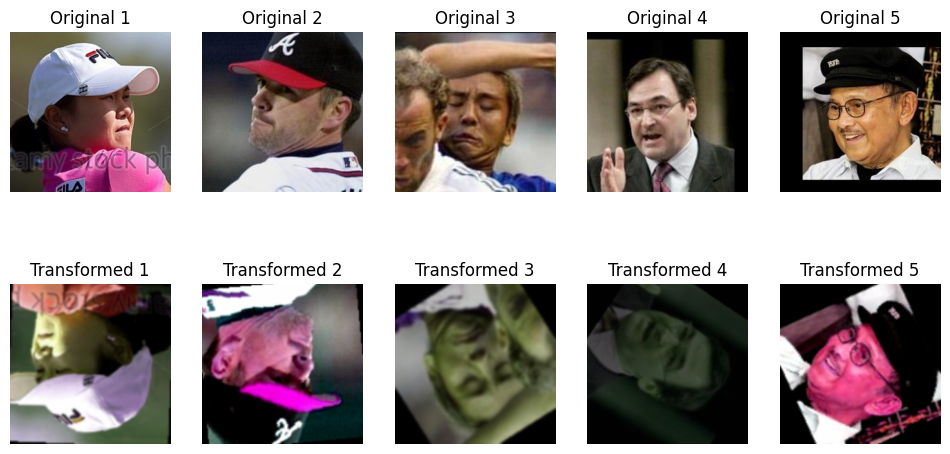

In [73]:

plot_images(image_list[:5], transformed_images[:5])
plt.show()

Для изображений OOD я выбрала изображения из датасета places365 (https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://www.kaggle.com/datasets/benjaminkz/places365&ved=2ahUKEwiSq4bNrK6IAxVY_7sIHQ-GNpUQFnoECBMQAQ&usg=AOvVaw24rqMASIdmUaTuiWI_iEBd) из тестовой выборки (и рандомно выбрала примерно 1500 из них)

In [74]:
nature_images = [Image.open(path) for path in get_image_paths("test_samples")]

In [75]:
for img in nature_images:
    img = img.resize((160,160), Image.ANTIALIAS)

<ipython-input-75-4180a8268ce5>:2: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((160,160), Image.ANTIALIAS)


In [ ]:
Составляю OOD датасет:

In [77]:
import random
ood_dataset = nature_images + transformed_images[:150]

In [78]:
from utils import compare
res = compare(face_model, 'id_samples/Joan_Dangerfield_1.jpg', 'transformed/image_1.jpg')
res['equal']

True

Проверка, что в трансформированных находится более 50 близких изображений

In [2]:
count = 0
for tr,orig in zip(transformed_img_paths[:150], ood_image_paths[:150]):
  res = compare(face_model, tr, orig)
  if res['equal']:
    count += 1
count


NameError: name 'transformed_img_paths' is not defined

In [3]:
def save_images(image_list, save_directory):
    
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    for i, img in enumerate(image_list):
        file_path = os.path.join(save_directory, f'image_{i}.png')
        
        img.save(file_path)


In [4]:
save_images(ood_dataset, "ood/")

NameError: name 'ood_dataset' is not defined